In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Data set
Atfirst read the dataset. The ner_dataset.csv contains sentence no, word, parts of speech and tags for the NER task. As we do not need the POSs, we drop this column. 

In [2]:
data = pd.read_csv("../input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


Now we get the unique words and the unique tags. Later we need to pad the sentences to the maximum length. For this we use a dummy word 'PADword'.

In [3]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35179

In [4]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
n_tags

17

In [5]:
tags

['B-tim',
 'I-eve',
 'B-art',
 'I-org',
 'B-nat',
 'B-org',
 'I-art',
 'I-per',
 'B-per',
 'I-geo',
 'O',
 'I-gpe',
 'I-nat',
 'B-gpe',
 'B-eve',
 'I-tim',
 'B-geo']

Now we need a way to make touples containing words and tags. For this, we declear the SentenceGetter class. We also declear a method get_next() for debugging and visualization purpose.

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

Let's have a look how a sentence looks like after converting it into a list of (word, tag) tuples. Letter we fetch all the sentences as a list of tuples. 

In [7]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [8]:
sentences = getter.sentences
print(len(sentences))

47959


In [9]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 104 words


length distribution of the sentences. 

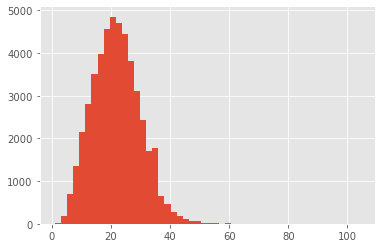

In [10]:
%matplotlib inline
plt.hist([len(sen) for sen in sentences], bins= 50)
plt.show()

In [11]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

25623
16


In [12]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)
new_X[15]

['Israeli',
 'officials',
 'say',
 'Prime',
 'Minister',
 'Ariel',
 'Sharon',
 'will',
 'undergo',
 'a',
 'medical',
 'procedure',
 'Thursday',
 'to',
 'close',
 'a',
 'tiny',
 'hole',
 'in',
 'his',
 'heart',
 'discovered',
 'during',
 'treatment',
 'for',
 'a',
 'minor',
 'stroke',
 'suffered',
 'last',
 'month',
 '.',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword',
 'PADword']

In [13]:
from keras.preprocessing.sequence import pad_sequences
y = [[tags2index[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])
y[15]

array([13, 10, 10,  8,  7,  7,  7, 10, 10, 10, 10, 10,  0, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)

In [14]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(new_X, y, test_size=0.1, random_state=2018)

In [15]:
batch_size = 32
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.compat.v1.keras import backend as K
sess = tf.Session()
K.set_session(sess)

In [16]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [17]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [18]:

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [19]:

input_text = Input(shape=(max_len,), dtype=tf.string)
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=512, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [20]:
model = Model(input_text, out)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [21]:
X_tr, X_val = X_tr[:1213*batch_size], X_tr[-135*batch_size:]
y_tr, y_val = y_tr[:1213*batch_size], y_tr[-135*batch_size:]
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [22]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=3, verbose=1)

Train on 38816 samples, validate on 4320 samples
Epoch 1/3
38816/38816 [==============================] - 529s 14ms/sample - loss: 0.0630 - acc: 0.9817 - val_loss: 0.0459 - val_acc: 0.9858
Epoch 2/3
38816/38816 [==============================] - 532s 14ms/sample - loss: 0.0408 - acc: 0.9868 - val_loss: 0.0420 - val_acc: 0.9866
Epoch 3/3
38816/38816 [==============================] - 544s 14ms/sample - loss: 0.0340 - acc: 0.9885 - val_loss: 0.0405 - val_acc: 0.9870


In [23]:
X_te = X_te[:149*batch_size]
test_pred = model.predict(np.array(X_te), verbose=1)

In [24]:

idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(y_te[:149*32])

In [25]:
i = 390
p = model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:15}: ({})".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:15} ({})".format(w, tags[pred], tags[true]))

Word            Predicted tag  : (True tag)
Citing         :O               (O)
a              :O               (O)
draft          :O               (O)
report         :O               (O)
from           :O               (O)
the            :O               (O)
U.S.           :B-org           (B-org)
Government     :I-org           (I-org)
Accountability :I-org           (O)
office         :O               (O)
,              :O               (O)
The            :B-org           (B-org)
New            :I-org           (I-org)
York           :I-org           (I-org)
Times          :I-org           (I-org)
said           :O               (O)
Saturday       :B-tim           (B-tim)
the            :O               (O)
losses         :O               (O)
amount         :O               (O)
to             :O               (O)
between        :O               (O)
1,00,000       :O               (O)
and            :O               (O)
3,00,000       :O               (O)
barrels        :O           